In [32]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

import util
import util_figures


def map_tag_model_to_x(tag_model):
    """
    Maps model names to phase locking limit values
    """
    if "IHC3000" in tag_model:
        return 3000
    elif "IHC1000" in tag_model:
        return 1000
    elif "IHC0320" in tag_model:
        return 320
    elif "IHC0050" in tag_model:
        return 50
    else:
        raise ValueError(f"Did not recognize {tag_model=}")


dir_fig = "figures_revision1"


In [33]:
"""
Specify data files and `dict_tag_model`, which maps shorthand keys to
all model tags (directories used to identify models in the data files)
"""

# These files contain results from all model experiments
fn_data_localization = "data/model/sound_localization.pkl"
fn_data_spkr_word = "data/model/spkr_word_recognition.pkl"

# These files contain human-model comparison metrics for all experiments
fn_comparison_localization = "data/model/sound_localization_human_model_comparison_metrics.pkl"
fn_comparison_spkr_word = "data/model/spkr_word_recognition_human_model_comparison_metrics.pkl"

dict_tag_model = {
    "localization": {
        "3000_delayed": "models/sound_localization/IHC3000_delayed_integration/arch??",
        "3000": "models/sound_localization/IHC3000/arch??",
        "1000": "models/sound_localization/IHC1000/arch??",
        "320": "models/sound_localization/IHC0320/arch??",
        "50": "models/sound_localization/IHC0050/arch??",
        "3000_delayed_simple": "models/sound_localization/simplified_IHC3000_delayed_integration/arch??",
        "3000_simple": "models/sound_localization/simplified_IHC3000/arch??",
        "1000_simple": "models/sound_localization/simplified_IHC1000/arch??",
        "320_simple": "models/sound_localization/simplified_IHC0320/arch??",
        "50_simple": "models/sound_localization/simplified_IHC0050/arch??",
    },
    "spkr_word": {
        "3000": "models/spkr_word_recognition/IHC3000/arch0_00??",
        "1000": "models/spkr_word_recognition/IHC1000/arch0_00??",
        "320": "models/spkr_word_recognition/IHC0320/arch0_00??",
        "50": "models/spkr_word_recognition/IHC0050/arch0_00??",
        "3000_simple": "models/spkr_word_recognition/simplified_IHC3000/arch0_00??",
        "1000_simple": "models/spkr_word_recognition/simplified_IHC1000/arch0_00??",
        "320_simple": "models/spkr_word_recognition/simplified_IHC0320/arch0_00??",
        "50_simple": "models/spkr_word_recognition/simplified_IHC0050/arch0_00??",
    },
}


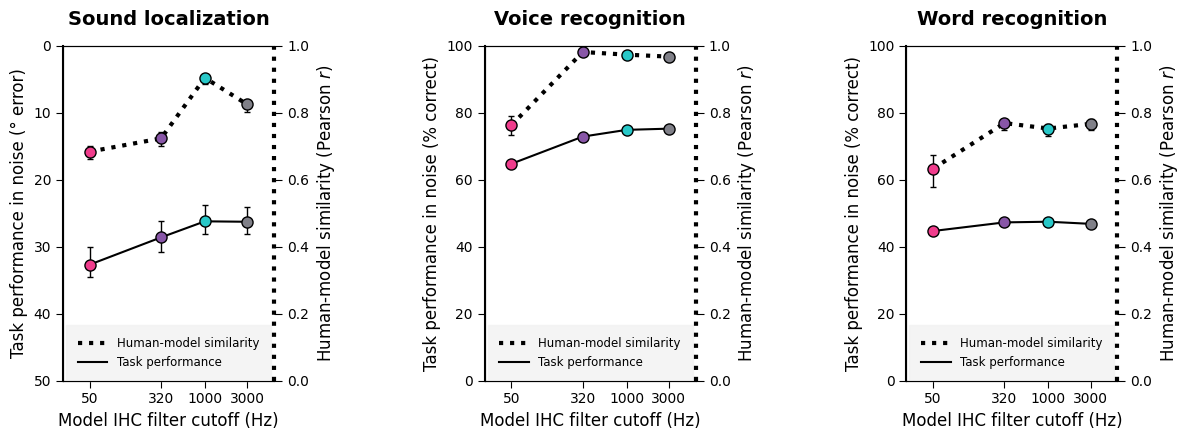

### WROTE: figures_revision1/results_summary_by_task.pdf ###
Comparing `performance` between `3000` and `3000_delayed`: p=0.4050, cohen_d=0.7829
Comparing `pearsonr` between `3000` and `3000_delayed`: p=0.0000, cohen_d=12.0122


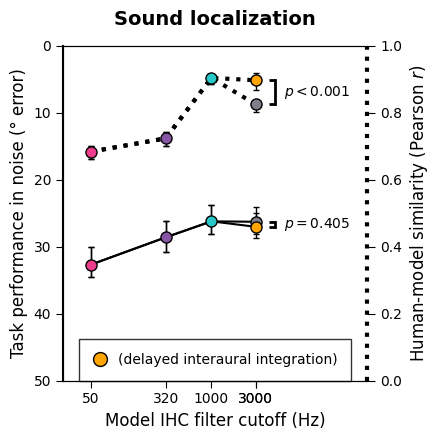

### WROTE: figures_revision1/results_summary_by_task_localization.pdf ###


In [34]:
"""
Aggregate measures figures: plot overall task-performance and
human-model similarity as a function of phase locking limit
"""

key_metric0 = "performance"
key_metric1 = "pearsonr"

list_list_key_task = [
    ["localization", "spkr", "word"],
    ["localization"],
]
for list_key_task in list_list_key_task:
    list_k = [
        "50",
        "320",
        "1000",
        "3000",
    ]
    if len(list_key_task) == 1:
        list_k.append("3000_delayed")
    ncols = len(list_key_task)
    fig, ax_arr = plt.subplots(nrows=1, ncols=ncols, figsize=(max(4 * ncols, 4.5), 4.5))
    ax_arr = np.array(ax_arr).reshape([ncols])
    for itr0, key_task in enumerate(list_key_task):
        if key_task in ["spkr", "word"]:
            list_tag_model = [dict_tag_model["spkr_word"].get(k, None) for k in list_k]
        else:
            list_tag_model = [dict_tag_model[key_task].get(k, None) for k in list_k]
        list_tag_model = [_ for _ in list_tag_model if _ is not None]
        ax0 = ax_arr[itr0]
        ax1 = ax0.twinx()
        for itr1, (ax, key_metric) in enumerate(zip([ax0, ax1], [key_metric0, key_metric1])):
            list_y, list_y_dist = util.get_aggregate_measure(
                fn_data_localization=fn_data_localization,
                fn_data_spkr_word=fn_data_spkr_word,
                fn_comparison_localization=fn_comparison_localization,
                fn_comparison_spkr_word=fn_comparison_spkr_word,
                list_tag_model=list_tag_model,
                key_task=key_task,
                key_metric=key_metric,
            )
            x = np.array([map_tag_model_to_x(_) for _ in list_tag_model])
            y = np.array(list_y)
            yerr = np.abs(np.percentile(np.array(list_y_dist), [0.0025, 0.9975], axis=1) - y)
            kwargs_errorbar = {
                "color": "k",
                "capsize": 2,
                "capthick": 1,
                "elinewidth": 1,
                "ls": "",
                "marker": "",
                "lw": 3 if itr1 else 1.5,
                "ls": ":" if itr1 else "-",
                "zorder": -1,
                "label": "Human-model similarity" if itr1 else "Task performance",
            }
            if len(x) == 5:
                if len(list_key_task) == 1:
                    kwargs_errorbar.pop("label", None)
                ax.errorbar(x[:4], y[:4], yerr[:, :4], **kwargs_errorbar)
                kwargs_errorbar.pop("label", None)
                ax.errorbar(x[[0, 1, 2, 4]], y[[0, 1, 2, 4]], yerr[:, [0, 1, 2, 4]], **kwargs_errorbar)
                if len(list_key_task) == 1:
                    ax.plot(
                        [x[4] * 1.6] * 2,
                        y[3:],
                        marker=0,
                        color="k",
                        lw=2,
                        mew=2,
                        ms=4)
                    y_ref_dist = list_y_dist[-2]
                    y_cmp_dist = list_y_dist[-1]
                    y_cmp = list_y[-1]
                    p_val = util.get_p_val(y_ref_dist, y_cmp)
                    d_val = util.cohend(y_ref_dist, y_cmp_dist)
                    print("Comparing `{}` between `{}` and `{}`: p={:.4f}, cohen_d={:.4f}".format(
                        key_metric,
                        list_k[-2],
                        list_k[-1],
                        p_val,
                        util.cohend(y_ref_dist, y_cmp_dist),
                    ))
                    str_text = "$p<0.001$" if p_val < 0.001 else "$p={:.3f}$".format(p_val)
                    ax.text(
                        x[4] * 2,
                        np.exp(np.mean(np.log(y[3:]))),
                        str_text,
                        ha="left",
                        va="center",
                        fontsize=10,
                        fontweight="bold")
            else:
                ax.errorbar(x, y, yerr, **kwargs_errorbar)
            for x_, y_, tag_model in zip(x, y, list_tag_model):
                color, _ = util.get_color_and_label_from_model_tag(tag_model)
                kwargs_plot = {
                    "color": color,
                    "marker": "o",
                    "ms": 8,
                    "ls": "",
                    "markeredgecolor": "k",
                    "mew": 1,
                }
                if "delayed" in tag_model:
                    kwargs_plot["color"] = "orange"
                    if len(list_key_task) == 1:
                        kwargs_plot["label"] = "(delayed interaural integration)"
                ax.plot(x_, y_, **kwargs_plot)
            kwargs_format_axes = {
                "xlimits": [25, 6000] if len(list_key_task) > 1 else [25, 6000 * 8],
                "xscale": "log",
                "xticks": x,
                "xticks_minor": [],
                "xticklabels": x,
                "fontsize_ticks": 10,
                "str_xlabel": "Model IHC filter cutoff (Hz)",
            }
            dict_kwargs_format_axes = {
                "pearsonr": {
                    "localization": {
                        "ylimits": [0, 1],
                        "yticks": [0, 0.2, 0.4, 0.6, 0.8, 1.0],
                        "str_ylabel": "Human-model similarity (Pearson $r$)",
                    },
                    "spkr": {
                        "ylimits": [0, 1],
                        "yticks": [0, 0.2, 0.4, 0.6, 0.8, 1.0],
                        "str_ylabel": "Human-model similarity (Pearson $r$)",
                    },
                    "word": {
                        "ylimits": [0, 1],
                        "yticks": [0, 0.2, 0.4, 0.6, 0.8, 1.0],
                        "str_ylabel": "Human-model similarity (Pearson $r$)",
                    },
                },
                "performance": {
                    "localization": {
                        "ylimits": [50, 0],
                        "yticks": [50, 40, 30, 20, 10, 0],
                        "str_ylabel": "Task performance in noise (° error)",
                        "str_title": "Sound localization",
                    },
                    "spkr": {
                        "ylimits": [0, 100],
                        "yticks": [0, 20, 40, 60, 80, 100],
                        "str_ylabel": "Task performance in noise (% correct)",
                        "str_title": "Voice recognition",
                    },
                    "word": {
                        "ylimits": [0, 100],
                        "yticks": [0, 20, 40, 60, 80, 100],
                        "str_ylabel": "Task performance in noise (% correct)",
                        "str_title": "Word recognition",
                    },
                }
            }
            kwargs_format_axes.update(dict_kwargs_format_axes[key_metric][key_task])
            ax = util_figures.format_axes(ax, **kwargs_format_axes)
            if itr1:
                ax0.set_title(ax0.title.get_text(), pad=15, fontweight="bold", fontsize=14)
                ax1.spines["left"].set_linewidth(1.5)
                ax0.spines["right"].set_visible(0)
                ax1.spines["right"].set_linestyle(":")
                ax1.spines["right"].set_linewidth(3)
                ax1.spines["right"].set_capstyle("butt")
                major_tick_params_kwargs = {
                    "axis": "both",
                    "which": "major",
                    "labelsize": 10,
                    "length": 12/2,
                    "direction": "out",
                }
                ax1.tick_params(**major_tick_params_kwargs)
            if len(x) == 5 and len(list_key_task) == 1:
                kwargs_legend = {
                    "loc": "lower center",
                    "frameon": True,
                    "fancybox": False,
                    "edgecolor": "k",
                    "borderaxespad": 0,
                    "borderpad": 1.0,
                    "markerscale": 1.25,
                    "handlelength": 1,
                }
                ax0.legend(**kwargs_legend)
            else:
                h0, l0 = ax0.get_legend_handles_labels()
                h1, l1 = ax1.get_legend_handles_labels()
                h = h1 + h0
                l = l1 + l0
                h = [_[0] for _ in h]
                kwargs_legend = {
                    "loc": "lower center",
                    "frameon": True,
                    "fancybox": False,
                    "edgecolor": [0.95] * 3,
                    "facecolor": [0.95] * 3,
                    "borderaxespad": 0,
                    "borderpad": 1,
                    "markerscale": 0,
                    "handlelength": 2.5,
                    "fontsize": 8.5,
                }
                leg = ax0.legend(h, l, **kwargs_legend)
    fig.tight_layout()
    fig.subplots_adjust(wspace=1)
    plt.show()

    fn_fig = "results_summary_by_task_localization.pdf" if len(list_key_task) == 1 else "results_summary_by_task.pdf"
    fn_fig = os.path.join(dir_fig, fn_fig)
    fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)
    print(f"### WROTE: {fn_fig} ###")


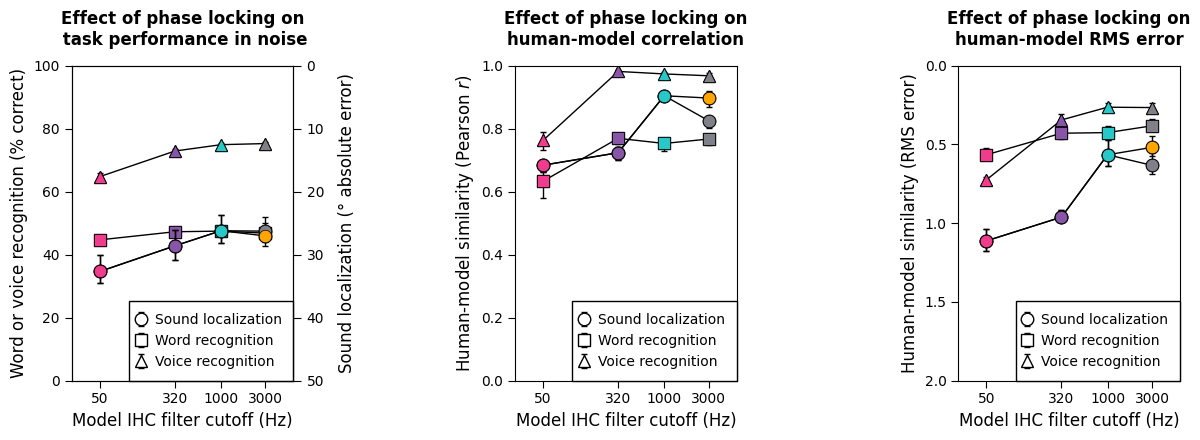

### WROTE: figures_revision1/results_summary_grid_alternate.pdf ###


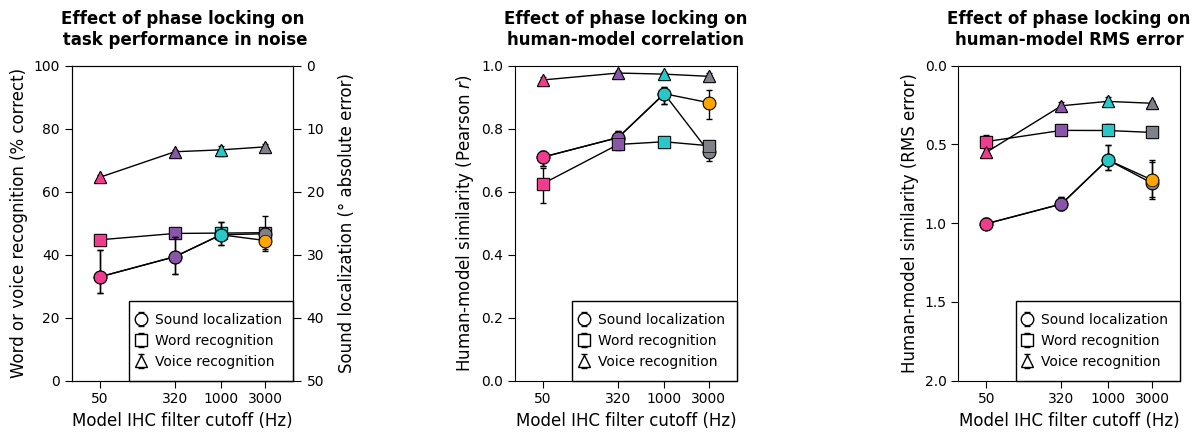

### WROTE: figures_revision1/results_summary_grid_alternate_simple.pdf ###


In [35]:
"""
Aggregate measures figures: plot overall task-performance and
human-model similarity as a function of phase locking limit

Generates figures for the both the detailed and simplified
peripheral auditory model (and includes RMS error metric)
"""

list_dict_list_k = [
    {
        "localization": ["50", "320", "1000", "3000", "3000_delayed"],
        "word": ["50", "320", "1000", "3000"],
        "spkr": ["50", "320", "1000", "3000"],
    },
    {
        "localization": ["50_simple", "320_simple", "1000_simple", "3000_simple", "3000_delayed_simple"],
        "word": ["50_simple", "320_simple", "1000_simple", "3000_simple"],
        "spkr": ["50_simple", "320_simple", "1000_simple", "3000_simple"],
    },
]
list_key_metric = [
    "performance",
    "pearsonr",
    "rmse",
]
dict_kwargs_format_axes_update = {
    "pearsonr": {
        "ylimits": [0, 1],
        "yticks": np.arange(0.0, 1.01, 0.2),
        "str_ylabel": "Human-model similarity (Pearson $r$)",
        "str_title": "Effect of phase locking on\nhuman-model correlation",
    },
    "rmse": {
        "ylimits": [2, 0],
        "yticks": np.arange(2.0, -0.1, -0.5),
        "str_ylabel": "Human-model similarity (RMS error)",
        "str_title": "Effect of phase locking on\nhuman-model RMS error",
    },
    "performance": {},
}
kwargs_plot_update = {
    "localization": {"label": "Sound localization", "marker": "o"},
    "word": {"label": "Word recognition", "marker": "s"},
    "spkr": {"label": "Voice recognition", "marker": "^"},
}

for dict_list_k in list_dict_list_k:
    ncols = len(list_key_metric)
    fig, ax_arr = plt.subplots(nrows=1, ncols=ncols, figsize=(4 * ncols, 4.5), sharex=True)
    ax_arr = np.array(ax_arr).reshape([ncols])
    for itr_metric, key_metric in enumerate(list_key_metric):
        DOUBLE_AXIS = ("localization" in dict_list_k) and (len(dict_list_k) > 1) and (key_metric == "performance")
        ax0 = ax_arr[itr_metric]
        for itr_task, key_task in enumerate(dict_list_k.keys()):
            list_k = dict_list_k[key_task]
            if ("localization" in key_task) and DOUBLE_AXIS:
                ax1 = ax0.twinx()
                ax = ax1
            else:
                ax = ax0
            if key_task in ["spkr", "word"]:
                list_tag_model = [dict_tag_model["spkr_word"].get(k, None) for k in list_k]
            else:
                list_tag_model = [dict_tag_model[key_task].get(k, None) for k in list_k]
            list_tag_model = [_ for _ in list_tag_model if _ is not None]
            kwargs_format_axes_update = dict(dict_kwargs_format_axes_update[key_metric])
            list_y, list_y_dist = util.get_aggregate_measure(
                fn_data_localization=fn_data_localization,
                fn_data_spkr_word=fn_data_spkr_word,
                fn_comparison_localization=fn_comparison_localization,
                fn_comparison_spkr_word=fn_comparison_spkr_word,
                list_tag_model=list_tag_model,
                key_task=key_task,
                key_metric=key_metric,
            )
            x = np.array([map_tag_model_to_x(_) for _ in list_tag_model])
            y = np.array(list_y)
            yerr = np.abs(np.percentile(np.array(list_y_dist), [0.0025, 0.9975], axis=1) - y)
            kwargs_errorbar = {
                "color": "k",
                "capsize": 2,
                "capthick": 1,
                "elinewidth": 1,
                "ls": "",
                "ms": 9,
                "lw": 1,
                "ls": "-",
                "mfc": "w",
                "zorder": -1,
            }
            kwargs_errorbar.update(kwargs_plot_update[key_task])
            if len(x) == 5:
                ax.errorbar(x[:4], y[:4], yerr[:, :4], **kwargs_errorbar)
                kwargs_errorbar.pop("label", None)
                ax.errorbar(x[[0, 1, 2, 4]], y[[0, 1, 2, 4]], yerr[:, [0, 1, 2, 4]], **kwargs_errorbar)
            else:
                ax.errorbar(x, y, yerr, **kwargs_errorbar)
            for x_, y_, tag_model in zip(x, y, list_tag_model):
                color, _ = util.get_color_and_label_from_model_tag(tag_model)
                if "delayed" in tag_model:
                    color = "orange"
                kwargs_plot = {
                    "color": color,
                    "marker": kwargs_errorbar["marker"],
                    "ms": kwargs_errorbar["ms"],
                    "ls": "",
                    "markeredgecolor": "k",
                    "mew": 0.5,
                }
                ax.plot(x_, y_, **kwargs_plot)
        kwargs_format_axes = {
            "xscale": "log",
            "xlimits": [25, 6000],
            "xticks": x,
            "xticks_minor": [],
            "xticklabels": x,
            "ylimits": [0, 100],
            "yticks": np.arange(0, 101, 20),
            "str_ylabel": "Word or voice recognition (% correct)",
            "str_xlabel": "Model IHC filter cutoff (Hz)",
            "str_title": "Effect of phase locking on\n task performance in noise",
            "fontweight_title": "bold",
            "fontsize_ticks": 10,
        }
        kwargs_format_axes.update(kwargs_format_axes_update)
        ax = util_figures.format_axes(ax, **kwargs_format_axes)
        h, l = ax.get_legend_handles_labels()
        if DOUBLE_AXIS:
            ax1.invert_yaxis()
            yticks = np.arange(0, 51, 10)
            ax1.set_yticks(yticks)
            ax1.set_yticklabels(yticks, fontsize=12)
            ax1.set_ylabel("Sound localization (° absolute error)", fontsize=12, labelpad=10)
            major_tick_params_kwargs = {
                "axis": "both",
                "which": "major",
                "labelsize": 10,
                "length": 12/2,
                "direction": "out",
            }
            ax1.tick_params(**major_tick_params_kwargs)
            h1, l1 = ax1.get_legend_handles_labels()
            h = h1 + h
            l = l1 + l
        if len(dict_list_k) > 1:
            kwargs_legend = {
                "loc": "lower right",
                "frameon": True,
                "framealpha": 1,
                "edgecolor": "k",
                "facecolor": "w",
                "borderaxespad": 0,
                "borderpad": 0.85,
                "handlelength": 0,
                "handletextpad": 1,
                "markerscale": 1,
                "fontsize": 10,
                "fancybox": False,
            }
            ax.legend(h, l, **kwargs_legend)
        ax.set_title(ax.title.get_text(), pad=15, fontweight="bold")
    fig.tight_layout()
    fig.subplots_adjust(wspace=1)
    plt.show()

    fn_fig = "results_summary_grid_alternate_simple.pdf" if "simple" in list_k[0] else "results_summary_grid_alternate.pdf"
    fn_fig = os.path.join(dir_fig, fn_fig)
    fig.savefig(fn_fig, bbox_inches='tight', pad_inches=0.05, transparent=False)
    print(f"### WROTE: {fn_fig} ###")


In [36]:
"""
Run statistical tests for the effect of phase locking manipulation (3000 vs 50 Hz
phase locking limit, within each task) and print out p-values and effect sizes
"""

list_key_task = [
    "localization",
    "spkr",
    "word",
]
list_key_metric = [
    "performance",
]
list_k = [
    "3000",
    "1000",
    "320",
    "50",
]
for key_task in list_key_task:
    for key_metric in list_key_metric:
        if key_task in ["spkr", "word"]:
            list_tag_model = [dict_tag_model["spkr_word"].get(k, None) for k in list_k]
        else:
            list_tag_model = [dict_tag_model[key_task].get(k, None) for k in list_k]
        list_tag_model = [_ for _ in list_tag_model if _ is not None]
        list_y, list_y_dist = util.get_aggregate_measure(
            fn_data_localization=fn_data_localization,
            fn_data_spkr_word=fn_data_spkr_word,
            fn_comparison_localization=fn_comparison_localization,
            fn_comparison_spkr_word=fn_comparison_spkr_word,
            list_tag_model=list_tag_model,
            key_task=key_task,
            key_metric=key_metric,
        )
        x = np.array([map_tag_model_to_x(_) for _ in list_tag_model])
        y = np.array(list_y)
        idx_ref = 0
        idx_cmp = -1
        y_ref_dist = list_y_dist[idx_ref]
        y_cmp_dist = list_y_dist[idx_cmp]
        y_ref = list_y[idx_ref]
        y_cmp = list_y[idx_cmp]
        p_val = util.get_p_val(y_ref_dist, y_cmp)
        d_val = util.cohend(y_ref_dist, y_cmp_dist)
        print("{} model: {} vs {}, p={:.4f}, cohen_d={:.4f}, difference_in_mean={:.4f} ({})".format(
            key_task,
            list_k[idx_cmp],
            list_k[idx_ref],
            p_val,
            d_val,
            y_ref - y_cmp,
            key_metric,
        ))


localization model: 50 vs 3000, p=0.0000, cohen_d=7.4047, difference_in_mean=-6.4034 (performance)
spkr model: 50 vs 3000, p=0.0000, cohen_d=-28.7992, difference_in_mean=10.5027 (performance)
word model: 50 vs 3000, p=0.0000, cohen_d=-7.7954, difference_in_mean=2.1396 (performance)


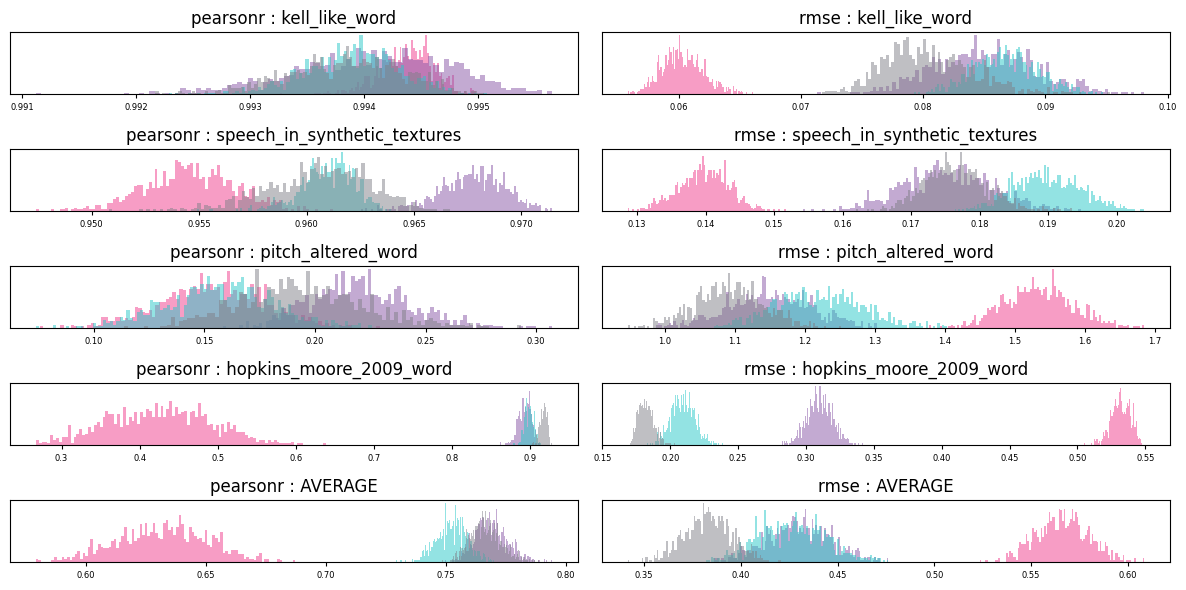

In [37]:
dict_tag_expt = {
    "localization": {
        "snr_dependency": "Sound localization in noise",
        "itd_ild_weighting": "ITD / ILD cue weighting (Macpherson & Middlebrooks, 2002)",
        "maa_azimuth": "Minimum audible angle vs. azimuth (Mills, 1958)",
        "itd_threshold": "ITD lateralization vs. frequency (Brughera et al., 2013)",
        "new_ears": "Effect of changing ears (Hofman et al., 1998)",
        "spectral_smoothing": "Effect of smoothing spectral cues (Kulkarni & Colburn, 1998)",
        "mp_spectral_cues": "Median plane spectral cues (Hebrank & Wright, 1974)",
        "precedence_effect_localization": "Precedence effect (Litovsky & Godar, 2010)",
        "bandwidth_dependency": "Bandwidth dependency (Yost & Zhong, 2014)",
    },
    "spkr": {
        "pitch_altered_spkr": "Voice recognition with pitch-altered speech",
    },
    "word": {
        "kell_like_word": "Word recognition as a function of SNR and noise condition",
        "speech_in_synthetic_textures": "Word recognition in 43 distinct auditory textures",
        "pitch_altered_word": "Word recognition with pitch-altered speech",
        "hopkins_moore_2009_word": "Effect of tone vocoding on word recognition in noise (Hopkins & Moore, 2009)",
    },
}

key_task = "word"
list_tag_expt = list(dict_tag_expt[key_task].keys())
list_k = [
    "3000_delayed",
    "3000",
    "1000",
    "320",
    "50",
    # "3000_delayed_simple",
    # "3000_simple",
    # "1000_simple",
    # "320_simple",
    # "50_simple",
]
if key_task in ["spkr", "word"]:
    list_tag_model = [dict_tag_model["spkr_word"].get(k, None) for k in list_k]
else:
    list_tag_model = [dict_tag_model[key_task].get(k, None) for k in list_k]
list_tag_model = [_ for _ in list_tag_model if _ is not None]

list_key_metric = ["pearsonr", "rmse"]
fig, ax_arr = plt.subplots(
    nrows=len(list_tag_expt) + 1,
    ncols=len(list_key_metric),
    figsize=(12, 1.5 * len(list_tag_expt)),
)
for c, key_metric in enumerate(list_key_metric):
    if "localization" in key_task:
        df = pd.read_pickle(fn_comparison_localization)
    else:
        df = pd.read_pickle(fn_comparison_spkr_word)
    df = df[np.logical_and.reduce([
        df.tag_model.isin(list_tag_model),
        df.tag_expt.isin(list_tag_expt),
    ])]
    assert df.tag_expt.nunique() == len(list_tag_expt)
    df = pd.concat([df, util.average_comparison_metrics(df)])
    for r, tag_expt in enumerate(df.tag_expt.unique()):
        ax = ax_arr[r, c]
        for tag_model in df.tag_model.unique():
            dfi = df[(df.tag_expt == tag_expt) & (df.tag_model == tag_model)].iloc[0]
            color, _ = util.get_color_and_label_from_model_tag(tag_model)
            if "delayed" in tag_model:
                color = "orange"
            ax.hist(dfi[f"bootstrap_list_{key_metric}"], 100, color=color, alpha=0.5)
        ax = util_figures.format_axes(
            ax,
            str_title=f"{key_metric} : {tag_expt}",
            yticks=[],
            yticklabels=[],
            # xlimits=[0, 1] if key_metric == "pearsonr" else [3, 0],
            fontsize_ticks=6,
        )
plt.tight_layout()
plt.show()
